In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Unit conversions
ps = 10**-12    # picoseconds unit
nm = 10**-9     # nanometers unit
um = 10 ** -6   # micrometer unit
    
# Physical parameters
RefractiveIndex = 1                         # unitless
speed_of_light = 299792458                  # in m/s
wavelength = 351 * nm                       # chosen wavelength
R = 25 * um                                 # radius of laser
E_L = 10 * (10 ** -6)                       # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2                      # area of laser
T_laser = 100 * ps                          # laser pulse time
I_0 = E_L / (Area_L * T_laser)              # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * RefractiveIndex * permittivity_free_space)) # Electric field SI unit is voltage / m

# time-step size “dt” is strictly controlled by Courant–Friedrichs–Lewy (CFL) condition 
#so that the wave propagation distance within a allowed time-step size cannot exceed the grid size “dx”.
CFL = 0.5
delta_x = 0.05 * wavelength
delta_t = CFL * delta_x / speed_of_light    # time related time-step

# Physics formulas
frequency = speed_of_light/wavelength       # in Hertz
angular_frequency = 2 * np.pi * frequency   # in Hertz
wavenumber = (2 * np.pi) / wavelength       # wave number 'k' will be imaginary part in the coming days (when we do it correctly)
period = wavelength / speed_of_light        # wave period (can also be calculated with 1/f)

# Grid and time parameters
lambda_mult = 10                    # represents number of cycles
T = lambda_mult * period            # modeling time
n_timestep = int(T/delta_t)         # n time step

L = wavelength * lambda_mult        # 'length' of simulation
n_cells = int(L/delta_x)            # number of cells (can also think of as number of grid points)

## Modeling the damping wave

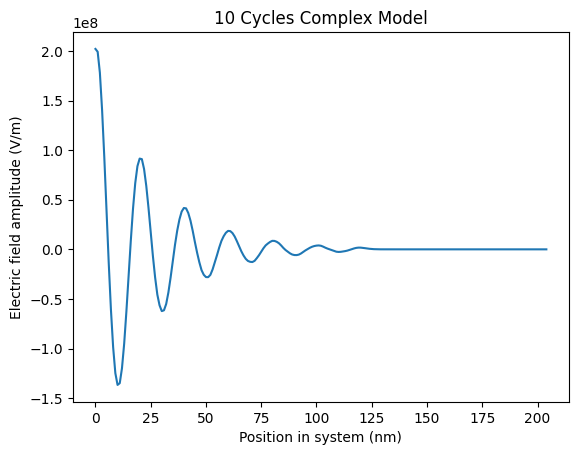

In [4]:
def complex_decaying_wave_soln(n_real, n_imaginary):

    # defining complex index of refraction (no imaginary yet)
    complex_refractive_index = complex(n_real, n_imaginary)
    complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index

    x = []  # spatial domain (can also think of as coordinates of grid points)
    t = []  # time domain

    # Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
    # The ghost cells are there so that in the matrix we can access all indeces
    # To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
    for i in range(-2, n_cells + 3):
        x.append(delta_x * (i + 0.5))

    for i in range(-2, n_timestep + 3):
        t.append(delta_t * (i + 0.5))

    x = np.array(x)
    t = np.array(t)

    E_complex = 1j * np.zeros((len(t), len(x))) # initializing imaginary matrix of dimensions (t, x)
    r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2 # our parameter

    # These loops will go through the grid. We start at 1 so as to not calculate the
    # value when the a time or spatial point is equal to 0.
    index = 0
    for n in range(1, (len(t) - 3)*1 + 0):
        t_sim = t[n] # in seconds

        # Defning cos and sin terms for wave to later be turned into complex numbers for t_nm1
        # Making sin zero because it is imaginary component
        cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
        sin_term_0_t_nm1 = 0

        cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
        sin_term_1_t_nm1 = 0

        # Initial conditions in time:
        E_complex[n-1, 0] = complex(cos_term_0_t_nm1, sin_term_0_t_nm1)
        E_complex[n-1, 1] = complex(cos_term_1_t_nm1, sin_term_1_t_nm1)


        # Defning cos and sin terms for wave to later be turned into complex numbers for t_n
        # Making sin zero because it is imaginary component
        cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
        sin_term_0_t_n = 0

        cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
        sin_term_1_t_n = 0

        # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
        E_complex[n, 0] = complex(cos_term_0_t_n, sin_term_0_t_n)
        E_complex[n, 1] = complex(cos_term_1_t_n, sin_term_1_t_n)

        # We have no laser on the left, so boundary conditions are just 0
        E_complex[n, -1] = complex(0)
        E_complex[n, -2] = complex(0)

        precision_num = 10
        for i in range(2, len(x) - 3):

            # explicit scheme
            E_complex[n+1, i] = np.exp(-complex_wavenumber.imag * x[i]) * ( (r_const_complex.real) * ( E_complex[n, i+1] - 2*E_complex[n, i] + E_complex[n, i-1] ) - ( -2*E_complex[n, i] + E_complex[n-1, i] ) )

            # this if block constrains the wave to inside our physical bounds
            if (True) and abs(E_complex[n+1, i])/abs(E_0) > 1:
                E_complex[n+1, i] = E_0 * np.sign(E_complex[n, i])

            index += 1
            
    return E_complex, x, t

E_complex_non_damped = complex_decaying_wave_soln(1, 0)

# Adding imaginary to damp wave
# re-defining complex index of refraction (adding imaginary part to force damping using analytical solution)
n_real = 1
n_i = 0.125
complex_refractive_index = complex(n_real, n_i)
complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index
E_complex_data = E_complex_non_damped[0]
E_complex_data_xdata = E_complex_non_damped[1]
E_complex_data_tdata = E_complex_non_damped[2]

format_title = "{} Cycles Complex Model".format(lambda_mult)
plt.title(format_title)
plt.xlabel("Position in system (nm)") # in entire simulation domain. Units of 10 ** -9 meters in SI units
plt.ylabel("Electric field amplitude (V/m)") # SI unit of volts / m
# Setting the x-axis to 1-10
# and y-axis to 1-15
# plt.axis([0, 200, -2*(10**8), 2*(10**8)])
# plt.plot(np.exp(-complex_wavenumber.imag * E_complex_data_xdata) * E_complex_data[int(int(E_complex_data.shape[0]/lambda_mult) * lambda_mult), :].real)
plt.plot(np.exp(-complex_wavenumber.imag * E_complex_data_xdata) * E_complex_data[int(int(250/lambda_mult) * lambda_mult), :].real)
plt.show()

In [15]:
# laser_intensity = S_xt / (-2 * complex_wavenumber)
laser_intensity = (speed_of_light * n_real * permittivity_free_space)/2 * (E_complex_data.real)**2
S_xt_ = -2 * complex_wavenumber * laser_intensity

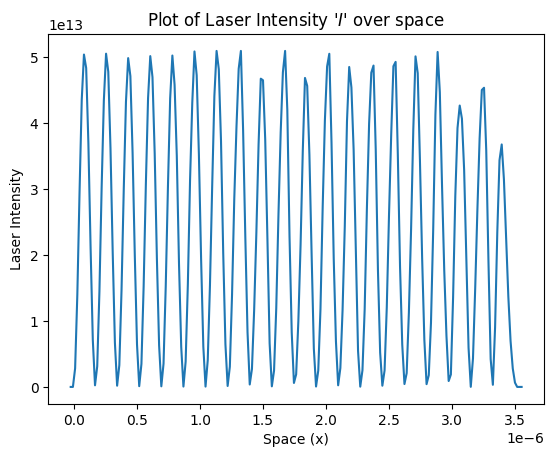

In [23]:
plt.plot(E_complex_data_xdata, laser_intensity[401,:])
plt.title("Plot of Laser Intensity '$I$' over space")
plt.xlabel("Space (x)")
plt.ylabel("Laser Intensity")
plt.show()

In [ ]:
Thickness = 1000 * nm
Nz = int(Thickness*um/wavelength_355nm)
dz = wavelength_355nm # m
dt = dz/lightSpeed*10 # s

laserI_probe_INC = probe_intensity # W/m^2 # laser intensity of probe pulse
alpha        = 10**(14)  # 1/s # rate of impact ionization
taur         = 10**(-12)*1000 # s   # electron recombination
nc_355nm     = get_nc(wavelength_355nm) # (1/m^3)
nc_450nm     = get_nc(wavelength_450nm) # (1/m^3)

# what are these? what should I set them as?
Ns_zone  = 6
Ns_edge  = 4
var_zone = np.zeros([Nz,Ns_zone])
 
# n_0 = 10**10*100**3 # 1/m^3 
# n_1 = 0             # 1/m^3 
# n_2 = 0             # 1/m^3
n_e = 0 # since I just do n_e, what do I initialize it as?
Te  = 0.025*eV # J
Ti  = 0.025*eV # J

# var_zone[:,0] = n_0 # 1/m^3 
# var_zone[:,1] = n_1 # 1/m^3 
# var_zone[:,2] = n_2 # 1/m^3
var_zone[:,0] = n_e
var_zone[:,1] = Te  # J
var_zone[:,2] = Ti  # J

t_start_wall = timeCheck.time()
hist         = []

pulse_IN = pulse_1
pulse_IN_Imax_TimePs = pulse_1_Imax_TimePs

time         = 0                         # s
time_step    = 0
for time_step in range(pulse_IN.shape[0]*1):
    
    laserI_INC   = pulse_IN[time_step,1]      # W/m^2
    laserE_INC   = get_laserE(laserI_INC,1)   # V/m with RefractiveIndex = 1
    time_current = pulse_IN[time_step,0]*ns   # s
    time_next    = pulse_IN[time_step+1,0]*ns # s
    ite_max      = int((time_next - time_current)/dt)
    
    ne_IN  = sum(var_zone[0,0:2])  # 1/m^3
    ne_OUT = sum(var_zone[-1,0:2]) # 1/m^3
    n_IN     = get_n(ne_IN,omega_355nm)  # unitless
    n_OUT    = get_n(ne_OUT,omega_355nm) # unitless 
    Te_IN    = var_zone[0,3]  # J
    Te_OUT   = var_zone[-1,3] # J 
    Ti_IN    = var_zone[0,4]  # J
    Ti_OUT   = var_zone[-1,4] # J     
    vc_IN    = get_vc_new(Te_IN,Ti_IN,ne_IN,n_a_CH,R_CH)   # 1/s
    vc_OUT   = get_vc_new(Te_OUT,Ti_OUT,ne_OUT,n_a_CH,R_CH)# 1/s    
    dU_IN, si_IN   = get_JH(ne_IN,vc_IN,omega_355nm,laserE,n_IN)
    dU_OUT, si_OUT = get_JH(ne_OUT,vc_OUT,omega_355nm,laserE,n_OUT) 
    Z_IN  = ne_IN/n_a_CH
    Z_OUT = ne_OUT/n_a_CH
    Z_QMD_IN  = get_Zeff(n_a_CH,Te_IN)
    Z_QMD_OUT = get_Zeff(n_a_CH,Te_OUT)

    print('time_step    = ',time_step)    
    print('time         = ',"{:.3e}".format(time/ps),' ps')
    print('time_current = ',"{:.3e}".format(time_current/ps),' ps')
    print('time_next    = ',"{:.3e}".format(time_next/ps),' ps')
    print('dt           = ',"{:.3e}".format(dt),' s')
    print('Te_IN, Te_OUT = ',"{:.3e}".format(Te_IN/eV),"{:.3e}".format(Te_OUT/eV),'eV')
    print('Ti_IN, Ti_OUT = ',"{:.3e}".format(Ti_IN/eV),"{:.3e}".format(Ti_OUT/eV),'eV') 
    print('ne_IN, ne_OUT = ',"{:.3e}".format(ne_IN),"{:.3e}".format(ne_OUT),'1/m^3')
    print('vc_IN, vc_OUT = ',"{:.3e}".format(vc_IN),"{:.3e}".format(vc_OUT),'1/s')
    print('dU_IN, dU_OUT = ',"{:.3e}".format(dU_IN),"{:.3e}".format(dU_OUT),'J/s/m^3') 
    print('si_IN, si_OUT = ',"{:.3e}".format(si_IN),"{:.3e}".format(si_OUT),'1/m') 
    print('Z_IN,  Z_OUT  = ',"{:.3e}".format(Z_IN),"{:.3e}".format(Z_OUT)) 
    print('Z_QMD_IN,Z_QMD_OUT = ',"{:.3e}".format(Z_QMD_IN),"{:.3e}".format(Z_QMD_OUT))
    print('Te_max        = ',"{:.3e}".format(max(var_zone[:,3])/eV),'eV')
    print('Ti_max        = ',"{:.3e}".format(max(var_zone[:,4])/eV),'eV')    
    print('ite_max       = ',ite_max)    

    for ite in range(ite_max):
        
        n_fe_max = np.max(var_zone[:,0]+var_zone[:,1]+var_zone[:,2]) # 1/m^3
        Te_max   = np.max(var_zone[:,3]) # J
        Ti_max   = np.max(var_zone[:,4]) # J

        laserI        = laserI_INC       # W/m^2     
        laserI_probe  = laserI_probe_INC # W/m^2
        laserE        = laserE_INC       # V/m   
        var_edge      = np.zeros([Nz+1,Ns_edge])
        var_edge[0,0] = 0      # m
        var_edge[0,1] = laserI # W/m^2
        var_edge[0,2] = laserE # V/m
        var_edge[0,3] = laserI_probe # W/m^2
        
        if 0 : 
            print()
            print('ite, time, n_fe_max, transimittance = ',
                  ite,
                  "{:.3e}".format(time),
                  "{:.3e}".format(n_fe_max),
                  "{:.3e}".format(laserI_probe/laserI_probe_INC),
                  "{:.3e}".format(laserI/laserI_INC))
            print('---')        

        for zone in range(1,Nz+1):
            i_zone = zone - 1 
            zp     = zone*dz     # m
            zm     = (zone-1)*dz # m

            n_0 = var_zone[i_zone,0] # 1/m^3
            n_1 = var_zone[i_zone,1] # 1/m^3
            n_2 = var_zone[i_zone,2] # 1/m^3
            Te  = var_zone[i_zone,3] # J
            Ti  = var_zone[i_zone,4] # J  

            n_fe  = n_0 + n_1 + n_2          # 1/m^3
            beta  = (n_vb_CH - n_fe)/n_vb_CH # no unit
            n_old = [n_0, n_1, n_2]          # 1/m^3   
            #####################################            
            #vc_OLD  = get_vc(Te/eV,Ti/eV,n_fe,n_a_CH,1)               # 1/s
            vc      = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            #vr      = get_vr(n_fe,Te) # 1/s
            #taur    = 1/vr # s
            #alpha   = get_vi(laserE,omega_355nm,Eg_CH,vc) # 1/s
            #####################################
            n       = get_n(n_fe,omega_355nm) # unitless  
            n_probe = get_n(n_fe,omega_450nm) # unitless     
            laserE       = get_laserE(laserI,n)             # V/m         
            laserE_probe = get_laserE(laserI_probe,n_probe) # V/m     
            Nmax      = 50
            WPI       = get_WPI(laserI,laserE,Nmax,omega_355nm,Eg_CH) # 1/(s.m^3)
            W1        = get_W1(laserE) # 1/s
            WPI_probe = get_WPI(laserI_probe,laserE_probe,Nmax,omega_450nm,Eg_CH) #1/(s.m^3)     
            dUdt_JH, sigma_JH       = get_JH(n_fe,vc,omega_355nm,laserE,n)
            dUdt_probe, sigma_probe = get_JH(n_fe,vc,omega_450nm,laserE_probe,n_probe) 
            
            #######################
            # Light Propagation
            #######################     
            dIdz             = - sigma_JH    * laserI       - WPI       * Eg_CH
            dIdz_probe       = - sigma_probe * laserI_probe - WPI_probe * Eg_CH
            laserI_new       = laserI       + dz * dIdz
            laserI_probe_new = laserI_probe + dz * dIdz_probe

            var_edge[zone,0] = zp                       # m
            var_edge[zone,1] = laserI_new               # W/m^2
            var_edge[zone,2] = get_laserE(laserI_new,n) # V/m
            var_edge[zone,3] = laserI_probe_new         # W/m^2 

            #######################
            # Electron Dynamics
            #######################
            source = [beta*WPI,0,0]                             # 1/s/m^3
            row1   = [-1/taur-W1,0,         2*alpha*beta      ] # 1/s
            row2   = [W1        ,-1/taur-W1,0                 ] # 1/s
            row3   = [0,        W1,         -1/taur-alpha*beta] # 1/s
            matrix = [row1, row2, row3]                         # 1/s
            n_new  = n_old + dt * (source + np.dot(matrix,n_old)) # 1/m^3
            n_0_new, n_1_new, n_2_new = n_new       # 1/m^3       
            n_fe_new = n_0_new + n_1_new + n_2_new  # 1/m^3
            dn_fe    = n_fe_new - n_fe              # 1/m^3

            var_zone[i_zone,0] = n_0_new # 1/m^3 
            var_zone[i_zone,1] = n_1_new # 1/m^3 
            var_zone[i_zone,2] = n_2_new # 1/m^3 

            #######################
            # Thermodynamics
            #######################
            #####################################
            #vc =  get_vc(Te,Ti,n_fe_new,n_a_CH,1) # 1/s 
            vc = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            #print('ite,vc = ',ite,vc)
            #####################################
            dUdt_JH, sigma_JH = get_JH(n_fe_new,vc,omega_355nm,laserE,n)
            Ce = get_Ce(n_fe_new) # 1/m^3
            Ci = get_Ci_new(n_a_CH,Ti)   # 1/m^3 
            G  = get_G(Ce,vc,Ti)     # 1/m^3/s
            #if Te <  Tc : G  = get_G(Ce,vc,'solid')     # 1/m^3/s
            #if Te >= Tc : G  = get_G(Ce,vc,'plasma')    # 1/m^3/s
            Qi = G*(Te-Ti)                             # J/s/m^3
            Qe = dUdt_JH - 1.5*Te*dn_fe/dt - G*(Te-Ti) # J/s/m^3            
            Te_new = Te + Qe*dt/Ce # eV
            Ti_new = Ti + Qi*dt/Ci # eV     

            var_zone[i_zone,3] = Te_new  # eV
            var_zone[i_zone,4] = Ti_new  # eV 

            laserI       = laserI_new
            laserI_probe = laserI_probe_new

            if (n_0_new < 0) or (n_1_new < 0) or (n_2_new < 0) :
                print('negative n_0, n_1, n_2 detected, STOP')
                break

            if (Te_new < 0) or (Ti_new < 0) :
                print('negative Te, Ti detected, STOP')
                print('Qe = ',Qe)
                break 

            if (laserI_new < 0) or (laserI_probe_new < 0) :
                print('negative laserI, laserI_probe detected, STOP')
                break 

            if (n_fe_new > nc_355nm) or (n_fe_new > nc_450nm) :
                print('negative n_fe exceed nc detected, STOP')
                break             

            #print(zone,laserI/laserI_INC)
            #print(zone,"{:.3e}".format(laserI_probe),"{:.3e}".format(laserI_probe_INC))
            #print(zone,laserI,laserI_new,laserI_probe,laserI_probe_new)
            #print(zone,"{:.3e}".format(n_0_new),"{:.3e}".format(n_1_new),"{:.3e}".format(n_2_new),
            #      ' : ',"{:.3e}".format(n_0),"{:.3e}".format(n_1),"{:.3e}".format(n_2))
            #print(zone,time,Te_new,Ti_new,' : ',Te,Ti)
            #print(zone,"{:.3e}".format(zp),"{:.3e}".format(time))
            
        time = time + dt
                    
    sol = [ne_IN,#0
           ne_OUT,#1
           n_IN,#2
           n_OUT,#3
           Te_IN,#4
           Te_OUT,#5
           vc_IN,#6
           vc_OUT,#7
           dU_IN,#8
           dU_OUT,#9
           si_IN,#10
           si_OUT,#11
           Ti_IN,#12
           Ti_OUT,#13 
           Z_IN,#14
           Z_OUT,#15
           Z_QMD_IN,#16
           Z_QMD_OUT#17           
          ]
        
    hist.append([time,#0
                 laserI_probe/laserI_probe_INC,#1
                 laserI/laserI_INC,#2
                 var_zone,#3
                 var_edge,#4
                 sol#5
                ])
        
    t_end_wall = timeCheck.time()
    print('Ray propagation completed in time_step : ',time_step)    
    print('t_end_wall - t_start_wall = ',int((t_end_wall-t_start_wall)/60),' minutes')
    print('time_ps,transimittance for probe and pump = ',
          "{:.3e}".format(time_current/ps-pulse_IN_Imax_TimePs),
          "{:.3e}".format(laserI_probe/laserI_probe_INC),
          "{:.3e}".format(laserI/laserI_INC))
    print('---')      
    
hist = np.array(hist)    

## RE-PLOT INTENSITY OVER POSITION